# <center> Parametric UMAP </center>

Play with the ParametricUMAP model and see if it can be used to train the reduction heads for our encoder model.

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Load the Sentence Embedding Model

In [2]:
# We will use the initial (untrained) all-mpnet-base-v2-compressed model
from reduced_encoders import MPNetCompressedModel

model_checkpoint = "cayjobla/all-mpnet-base-v2-compressed"
model = MPNetCompressedModel.from_pretrained(model_checkpoint, revision="initial").to(device)

/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
model.base_model

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

#### Load the Toy Dataset

In [4]:
from sklearn.datasets import fetch_20newsgroups
from datasets import Dataset

newsgroups = fetch_20newsgroups()
documents = Dataset.from_dict({"text":newsgroups.data, "target":newsgroups.target})

#### Embed the Data

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# Tokenize and get sentence embeddings in the data
def preprocess_data(batch):
    tokenized = tokenizer(batch["text"], truncation=True, padding="max_length", return_tensors="pt")
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = model.pooler(outputs[0], attention_mask) 
    return {"data": pooled_output.cpu().detach()}

embedding_dataset = documents.map(preprocess_data, batched=True, batch_size=250, remove_columns=documents.column_names).with_format("torch")

Map:   0%|          | 0/11314 [00:00<?, ? examples/s]

#### Define the ParametricUMAP Model

In [7]:
from umap_pytorch import PUMAP

umap = PUMAP()

2024-05-15 10:21:09.743571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 10:21:11.320575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Train the UMAP Model

In [8]:
# reduced_embeddings = umap.fit(embedding_dataset["data"].numpy()[:20])

### Here's where you're at...

Yesterday, it looked like they had merged the changes for ParametricUMAP to allow pytorch backends; however, the issue still says open when I look today. The problem resolves itself when changing the backend to tensorflow, so it's an implementation issue. For now, try to keep using the `umap_pytorch` port, though this previously resulted in issues of silent failure, potentially a result of memory errors.

After some testing, I can get the `umap_pytorch` model to train all the way through with a subset of the wikipedia dataset (3M embeddings), but the process is killed when I pass the full 6.47M vector dataset.

## After Training on 3,000,000 Sentence Embeddings (from wikipedia dataset)

In [9]:
from reduced_encoders import MPNetCompressedModel

model = MPNetCompressedModel.from_pretrained("all-mpnet-base-v2-compressed-umap")

In [10]:
def reduce(batch):
    reduce = model.reduce.to(device)
    with torch.no_grad():
        input_tensor = batch["data"].to(device)
        reduced_embedding = reduce(input_tensor)
    return {"data": reduced_embedding.cpu().detach()}

In [11]:
reduced_embeddings = embedding_dataset.map(reduce, batched=True, batch_size=250).with_format("torch")["data"]

Map:   0%|          | 0/11314 [00:00<?, ? examples/s]

### Try Clustering with HDBSCAN

In [12]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=5, min_samples=5, metric='euclidean', cluster_selection_method='eom')

In [13]:
clusters = clusterer.fit(reduced_embeddings)

In [14]:
import numpy as np

labels, counts = np.unique(clusters.labels_, return_counts=True)
print("Labels:", labels)
print("Counts:", counts)

Labels: [-1  0  1  2  3  4  5]
Counts: [  165    29     7 10043     8    13  1049]


In [15]:
from matplotlib import pyplot as plt
import pandas as pd

def visualize_space_2d(embeddings_2d, labels):
    """Plot the distribution of embedding vectors projected to 2 dimensions using UMAP."""
    df_emb = pd.DataFrame(embeddings_2d, columns=["X", "Y"])
    df_emb["label"] = labels

    # Plot
    num_labels = len(np.unique(labels))
    colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C8", "C9"]
    for i, label in enumerate(np.unique(labels)):
        color = "C7" if label == -1 else colors[i%len(colors)]
        df_emb_sub = df_emb.query(f"label == {label}")
        plt.scatter(df_emb_sub["X"], df_emb_sub["Y"], c=color, alpha=0.1)
        plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

In [16]:
from sklearn.decomposition import PCA

embeddings_2d = PCA(n_components=2).fit_transform(reduced_embeddings)

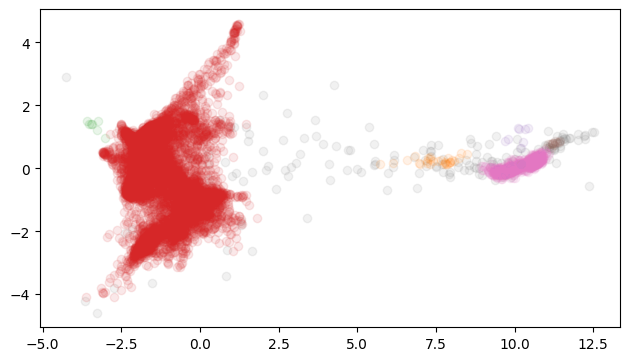

In [17]:
visualize_space_2d(embeddings_2d, clusters.labels_)

### Paint the original embeddings reduced with PCA

In [18]:
from sklearn.decomposition import PCA

embeddings_2d = PCA(n_components=2).fit_transform(embedding_dataset["data"])

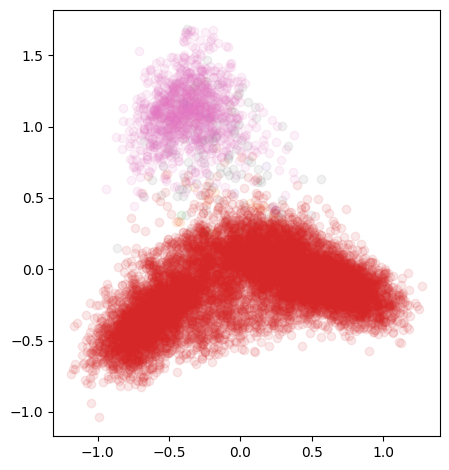

In [19]:
visualize_space_2d(embeddings_2d, clusters.labels_)

### What Next?

So, I've tried training these reduction heads 3 different ways now, and each time it seems to struggle. What is the problem? Is this not the right way to do things? What else can I do?

Here are some potential reasons why the model is not performing well:
* The current model has not been trained long enough / the encoder layers have not been fine-tuned
* None of the models have been fine-tuned specifically on the task at hand before evaluating clustering
* The layers are not large enough, and so the reduction does not convey enough meaning
* The reduction requires a different structure (maybe transformer layers?)
* The training dataset (wikipedia) is not broad enough to allow the trained model to be generalizeable
* By training on document embeddings for wikipedia, our "documents" are too long, and the sentence embeddings do not relate to our eval data
* The dimensionality of the reduced embeddings is not large enough (maybe we can try 64?)
* The encoder itself is not very good, resulting in poor document embeddings
* We are trying to make the reduction heads too broad by using the wikipedia dataset, and it should be more task-specific
* Maybe our eval dataset (newsgroups) is not good data

Ideas:
* Evaluate our current models on different datasets for clustering
* Finish up with the current model - try to finish training it
* Try fine-tuning one or more of our models on the task we are trying to do
* Try changing the model structure:
    - Add more layers, increase the sizes of the existing layers
    - Move away from dense layers (try transformers layers in an autoencoder?)
    - Increase the number of dimensions in the final reduced embeddings
    - Try a different sentence encoder? (SBERT still seems to be the top, so idk...)
* Try different training strategies:
    - Use a different dataset (either be more broad or more specific)
    - Change the amount of words pooled to get document embeddings (sentence-wise? => problem of having a lot more data)
    - Train with a variable reduction size (CompresSBERT with loss propagation through each layer)
    - For the CompresSBERT model, ensure that there are similar examples in each batch (how?)

Meanwhile:
* Try to implement HDBSCAN speedups (without rewriting everything; maybe try some inheritance and function overwriting?)
* Explore the viability of other clustering options